In [1]:
#!/usr/bin/env python3
#import your libraries
from imblearn.over_sampling import SMOTE
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
from sklearn.metrics import recall_score
from sklearn.metrics import precision_score
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import binarize
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
import time
import warnings
warnings.filterwarnings("ignore")



In [2]:
train_transaction = pd.read_csv('/Users/krahman/work/fraud_detection/data/train_transaction.csv')
train_identity = pd.read_csv('/Users/krahman/work/fraud_detection/data/train_identity.csv')
# merging dataframes 
df_raw = train_transaction.merge(train_identity, on='TransactionID', how='left')
df_train = df_raw.copy()

In [ ]:
# list(df_train.columns)

In [ ]:
# train_transaction.head() # KEEP

In [ ]:
# train_identity.head() # KEEP

In [ ]:
# train_transaction.info(); # KEEP

In [ ]:
# train_identity.info(); # KEEP

#### Data Quality Check

In [ ]:
# list_null = df_train.isnull().any()
# df_null = pd.DataFrame(list_null).reset_index()
# df_null

In [ ]:
# df_train.loc[:,df_train.isnull().any()]['id_34'].unique()

In [ ]:
# KEEP
# train_transaction_sum = train_transaction.duplicated().sum()
# train_identity_sum = train_identity.duplicated().sum()
# columns = train_transaction.columns
# print('Train transaction duplicates: {}\nTrain identity duplicates: {} \n'.format(train_transaction_sum, train_identity_sum))
# # print('Train feature columns:\n', list(columns))

In [ ]:
# df_train.isnull().any() # KEEP

In [ ]:
# df_train.info() # KEEP

In [ ]:
# df_train.dtypes # KEEP

#### EDA

In [ ]:
# How many transactions are in the dataset?
# df_train.shape # KEEP

In [ ]:
# What is the fraud rate of the data set?
# fraud_rate = df_train.isFraud.value_counts() / 590540
# fraud_rate  # KEEP

In [ ]:
# What is the statistical overview of the data set?
# df_train.describe() # KEEP

In [ ]:
# fraud_summary = df_train.groupby('isFraud')
# fraud_summary.mean()

In [ ]:
# fraud_summary.mean().to_csv('/Users/krahman/work/fraud_detection/saved_files/fraud_groupby.csv')

In [ ]:
# df_train.isnull().any()

### Assigning columns to specific lists (cat, num, date, etc.)

In [3]:
# dropping columns with more than 50% missing data
length_df = df_train.shape[0]/2
list_temp = []
for val in df_train.columns:
    if np.sum(df_train[val].isnull()) > length_df:
        list_temp.append(val)   
df_train = df_train.drop(list_temp, axis=1)

###################################
# c is num, ex, how many addresses associated with card
col_c = [c for c in df_train.columns if c.startswith('C') and (len(c)==2 or len(c)==3)]
# d is num, time/days between transactions
col_d = [d for d in df_train.columns if d.startswith('D') and (len(d)==2 or len(d)==3)]
# m is date of transaction
col_m = [m for m in df_train.columns if m.startswith('M') and (len(m)==2 or len(m)==3)]
# v is num, features created by vesta such as ranking, counting. entity relationships, etc. 
col_v = [v for v in df_train.columns if v.startswith('V') and (len(v)==2 or len(v)==3 or len(v)==4)]
# i is identity information like network and digital signature associated with transaction
col_i = [i for i in df_train.columns if i.startswith('id_') and len(i)==5]
# ca is cat, card information such as card type, etc. 
col_card = [ca for ca in df_train.columns if ca.startswith('card')]
# D = time elapsed between each transaction, card = card information, C = counting, ie how many addresses 
# associated with card, M=True/False, V created features on ranking, counting, etc. 

# column id and target
col_id = ['TransactionID']
col_target = 'isFraud'

# converting categorical columns with numerical values to string types.
col_cat_to_obj = ['addr1','addr2','card1','card2', 'card3', 'card5']
for val in col_cat_to_obj:
    df_train[val] = df_train[val].astype(str)

# categorical columns
col_cat = ['addr1','addr2','ProductCD',"P_emaildomain"] + col_card + col_m

# C counter, D is time elapsed between transactions, V feature engineered variables by firm
col_num = ['TransactionAmt'] + col_c + col_d + col_v 
col_num.append(col_target)

# figure out how to handle this. What do these dates mean? Do certain dates have more fraud occurences?
col_date = ['TransactionDT'] 

# boolean columns. convert via dummy variable. We dont know if true/false is better than one or the other. 
# col_bool = col_m

# confirming all columns are accounted for
print('Total columns: ' + str(len(col_cat + col_num + col_date + col_id + col_i)))

# columns removed dist1, dist2, R_emaildomain, DeviceInfo, DeviceType 

Total columns: 220


In [ ]:
class Preprocessing:
    def __init__(self):
        '''initialize variables and column names for null dataframe'''
        self.df_train = df_train.copy()
        self.list_col = []
        self.list_total = []
        self.dict_unique = {}
        self.list_datatype = []
        self.list_unique_val = []
        self.list_mode_count = []
        self.list_mode_value = []
        self.list_mode_count_perc = []
        self.list_unique_total = []
        self.list_unique_first_10 = []
        self.column_names = ['col_name', 'total_null', 'datatype', 'total_unique',
                             'mode_value', 'mode_count', 'mode_percentage']

    def missing_values(self):
        '''check for null values and add to null dataframe if more than 0 nulls exist'''
        for val in df_train.columns:
            total_null = np.sum(df_train[val].isnull())
            if total_null > 0:
                self.list_col.append(val)
                self.list_total.append(total_null)
                self.list_datatype.append(df_train[val].dtype)
                self.list_unique_total.append(len(df_train[val].unique()))
                self.list_unique_val.append(df_train[val].unique())
                self.list_mode_value.append(df_train[val].mode()[0])
#                 self.list_mode_value.append('MISSING')

                val_counts = max(df_train[val].value_counts())
                self.list_mode_count.append(val_counts)
                self.list_mode_count_perc.append(val_counts/len(df_train))
                val_unique = df_train[val].unique()
                self._create_dict(val_unique, df_train, val)
        df_null_info = self._create_dataframe()
        df_null_info = self._create_df_unique(df_null_info)
        self._summary(df_null_info)
        self._fillna(df_null_info)
        return df_null_info
    
    def _create_dict(self, val_unique, df_train, val):
        '''create dictionary of unique values for each column'''
        if (len(val_unique) > 99) and isinstance(df_train[val], object):  
            self.dict_unique.update([(val,0)])
        if (len(val_unique) > 99) and not isinstance(df_train[val], object):
            self.dict_unique.update([(val,0)])
        if len(val_unique) < 100:
            self.dict_unique.update([(val, val_unique)])

    def _create_dataframe(self):
        '''create main dataframe'''
        df_null_info = pd.DataFrame()
        counter = -1
        for list_val in [self.list_col, self.list_total, self.list_datatype, self.list_unique_total,
                        self.list_mode_value, self.list_mode_count, self.list_mode_count_perc]:
            counter = counter + 1
            col_title = self.column_names[counter]
            df = pd.DataFrame(list_val, columns=[col_title])
            df_null_info = pd.concat([df_null_info, df], axis=1)
        return df_null_info
    
    def _summary(self, df_null_info):
        val = df_null_info.shape[0]
        print('There were ' + str(val) + ' columns with null values.')
    
    def _create_df_unique(self, df_null_info):
        '''create unique values dataframe'''
        series_unique = pd.Series(self.dict_unique)
        df_unique = pd.DataFrame(series_unique).reset_index()
        df_unique = df_unique.rename(columns={'index':'col_name', 0:'unique'})
        df_null_info = df_null_info.merge(df_unique, how='left', 
                                          left_on='col_name', right_on='col_name')
        df_null_info.to_csv('/Users/krahman/work/fraud_detection/saved_files/df_null_info.csv')
        return df_null_info
    
    def _fillna(self, df_null_info):
        '''fill null values of df_train with mode'''
        total_null_columns = sum(np.sum(self.df_train.isnull()))
        if total_null_columns > 0:
            for val in df_null_info.col_name:
                val_mode = self.df_train[val].mode()[0]
                self.df_train[val] = self.df_train[val].fillna(val_mode)
#                 print("fillna," + str(val))
#                 self.df_train[val] = self.df_train[val].fillna('MISSING')
    
    def impute_features(self):
        df_temp = pp.df_train
        for val in col_cat:
            total_unique_val = pp.df_train[val].unique().shape[0]
            if len(df_temp[val].unique()) < 60:
                print('dummies encoded: ' + str(val) + ' unique ' + str(total_unique_val))
                df_dumm = pd.get_dummies(df_temp[val], prefix=val, drop_first=True)
                df_temp = df_temp.drop(val,axis=1)
                df_temp = pd.concat([df_temp, df_dumm], axis=1)
            else:
                le = LabelEncoder()
                df_temp[val] = le.fit_transform(df_temp[val])
                print('label encoded: ' + str(val) + ' unique ' + str(total_unique_val))
        print('new dataframe shape:' + str(df_temp.shape))
        return df_temp

pp = Preprocessing()
df_null_info = pp.missing_values()
# df_null_info
# TEST: test imputing with missing instead of mode to see if we have improvements in model 

In [ ]:
pp.df_train = pp.impute_features()
pp.df_train.to_csv('/Users/krahman/work/fraud_detection/saved_files/df_imputed.csv')

In [ ]:
# ['addr1', 'addr2', 'ProductCD', 'P_emaildomain', 'card1', 'card2', 'card3', 'card4', 
#  'card5', 'card6', 'M1', 'M2', 'M3', 'M4', 'M6']

In [4]:
df_features = pd.read_csv('/Users/krahman/work/fraud_detection/saved_files/df_imputed.csv')
df_features = df_features.drop('Unnamed: 0', axis=1)

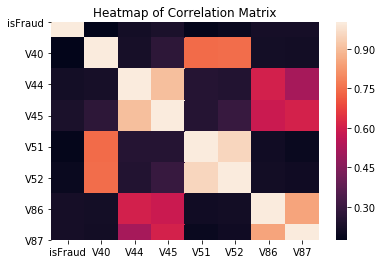

,isFraud,V40,V44,V45,V51,V52,V86,V87
isFraud,1.000000,0.174672,0.217870,0.235436,0.182007,0.195492,0.222343,0.221568
V40,0.174672,1.000000,0.225232,0.271469,0.744831,0.745758,0.217055,0.213533
V44,0.217870,0.225232,1.000000,0.905537,0.257145,0.251881,0.604776,0.515480
V45,0.235436,0.271469,0.905537,1.000000,0.257400,0.296102,0.585396,0.608788
V51,0.182007,0.744831,0.257145,0.257400,1.000000,0.954315,0.212453,0.196567
V52,0.195492,0.745758,0.251881,0.296102,0.954315,1.000000,0.215183,0.207535
V86,0.222343,0.217055,0.604776,0.585396,0.212453,0.215183,1.000000,0.850021
V87,0.221568,0.213533,0.515480,0.608788,0.196567,0.207535,0.850021,1.000000


In [5]:
fraud_summary = df_features.groupby('isFraud')
fraud_summary.mean().to_csv('/Users/krahman/work/fraud_detection/saved_files/fraud_summary.csv')

corr = df_features.corr()
corr.to_csv('/Users/krahman/work/fraud_detection/saved_files/corr_matrix.csv')
corr2 = corr[corr['isFraud']>.17]
corr2 = corr2.loc[:,corr2.index]

sns.heatmap(corr2,
           xticklabels=corr2.columns.values,
           yticklabels=corr2.columns.values)
plt.title('Heatmap of Correlation Matrix')
plt.show()
corr2

In [ ]:
# plt.figure(figsize=(14,4))
# sns.barplot(x='V44', y='V44', hue='isFraud', data=df_train)
# plt.show()

# sns.lmplot(x='addr1', y='addr2', data=df_features,
#            fit_reg=False, hue='isFraud')
# plt.show()

# sns.distplot(df_features.addr1)
# plt.show()

# plt.scatter(X.card1, y)
# sns.regplot(x='card5_237.0', y='isFraud', data=pp.df_train, logistic=True, color='b')

## Splitting features dataframe

In [ ]:
# # create features, target and split the dataframe
# X = pp.df_train.drop(col_target, axis=1)
# X = X.drop(col_id, axis=1)
# y = pp.df_train[col_target]
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.1, random_state=42)

In [ ]:
# X = df_features.drop(col_target, axis=1)
# X = X.drop(col_id, axis=1)
# y = df_features[col_target]
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.2, random_state=42)

### Test Dropping Features On Base Model

In [ ]:
# ###DELETE

# class Results():
#     def __init__(self):
#         self.model_lr_results = pd.DataFrame()
#         self.model_recall = []
#         self.model_precision = []
# #         self.model_auc_score = []
        
#     def _score(self, y_true, y_pred):
#         self.model_recall.append(recall_score(y_true, y_pred))
#         self.model_precision.append(precision_score(y_true, y_pred))
#         self._create_series()
# #         self.model_auc_score.append(roc_auc_score(y_true, y_pred[:,1]))

#     def _create_series(self):
#         model_recall = pd.Series(self.model_recall, name='recall')
#         model_precision = pd.Series(self.model_precision, name='precision')
# #         model_auc_score = pd.Series(self.model_auc_score, name='auc_score')
#         model_results_final = pd.concat([model_recall, model_precision],axis=1)
#         return model_results_final

# df_temp = pd.DataFrame(pca.explained_variance_ratio_)
# df_temp[0:20]
# pd.DataFrame(pca.components_, columns=list(X_temp.columns), index=range(0,225))
# pca.components_

#### Applying PCA (2 components)

In [ ]:
# # standardizing our data, which is required for PCA.
# scaled_X = StandardScaler().fit_transform(X)

# # PCA instantiate and fit 
# pca = PCA(n_components=2)
# pcomponents = pca.fit_transform(scaled_X)
# X_pca = pd.DataFrame(data = pcomponents, columns=['PC1','PC2'])
# print(X_pca.shape)
# X_pca.head()

# # two principal components scatter plot
# plt.figure(figsize=(8,6))
# plt.scatter(X_pca['PC1'], X_pca['PC2'], c=y['isFraud'])
# plt.xlabel('First principal component')
# plt.ylabel('Second principal component')

# # explaining vaariance
# print('Variance ratio:')
# print(pca.explained_variance_ratio_)
# # interpreting principal components
# print('\nPrincipal components explained:')
# pd.DataFrame(pca.components_, columns=list(X.columns), index=('PC1', 'PC2'))

#### Applying PCA to all features (all components)

In [ ]:
# pca2 = PCA().fit(scaled_X)
# plt.plot(np.cumsum(pca2.explained_variance_ratio_))
# plt.xlabel('Number of Components')
# plt.ylabel('Variance (%)')
# plt.title('Credit Card Fraud Explained Variance')
# plt.show()

#### Model w/ SMOTE only - base model

In [ ]:
# X_train1, X_test1, y_train1, y_test1 = train_test_split(X, y, test_size=0.1, random_state=42)

# # Apply SMOTE
# sm = SMOTE(random_state=42, ratio=1.0, n_jobs=-1)
# X_train_res, y_train_res = sm.fit_sample(X_train1, y_train1)

# model_lr = LogisticRegression(random_state=42)
# model_lr.fit(X_train_res, y_train_res) 

# # predicting on test set w/o PCA
# print("Predicting using only SMOTE (and w/o PCA)\n")
# y_pred_test1 = model_lr.predict(X_test1)
# print("Test set:")
# print("Validation results")
# print(model_lr.score(X_test1, y_test1))
# print(recall_score(y_test1, y_pred_test1))
# print("\nConfusion Matrix")
# print(confusion_matrix(y_test1, y_pred_test1))
# print('\nClassification Report:\n')
# print(classification_report(y_test1, y_pred_test1))

# # predicting on original dataset
# print("Whole dataset:")
# y_pred = model_lr.predict(X)
# print("\nTest Results")
# print(model_lr.score(X, y))
# print(recall_score(y, y_pred))
# print("\nConfusion Matrix")
# print(confusion_matrix(y, y_pred))
# print('\nClassification Report:\n')
# print(classification_report(y, y_pred))

## Logistic Regression w/PCA  w/SMOTE

### EDA

In [ ]:
# sns.lmplot(x='addr1', y='addr2', data=df_features,
#            fit_reg=False, hue='isFraud')
# plt.title('addr1 versus addr2')
# plt.show()

# sns.distplot(df_features.addr1)
# plt.title('Addr1 Distribution')
# plt.show()

In [ ]:
# # EDA Email Class
# # P_emaildomain
# # list(df_train.columns)
# # df_train.P_emaildomain.unique()
# list_perc = []
# list_fraud_count = []
# list_non_fraud_count = []
# for val in df_train.P_emaildomain.unique():
#     non_fraud_count = df_train[(df_train.P_emaildomain==val) & (df_train.isFraud==0)].shape[0]
#     fraud_count = df_train[(df_train.P_emaildomain==val) & (df_train.isFraud==1)].shape[0]
    
#     list_perc.append(fraud_count/non_fraud_count)
    
#     list_fraud_count.append(fraud_count)
#     list_non_fraud_count.append(non_fraud_count)
    
# col_email = pd.Series(df_train.P_emaildomain.unique(), name='email')
# col_perc = pd.Series(list_perc, name='fraud_perc')
# col_fraud_count = pd.Series(list_fraud_count, name='fraud_count')
# col_non_fraud_count = pd.Series(list_non_fraud_count, name='non_fraud_count')

# # col_perc
# df_email_fe = pd.concat([col_email, col_perc, col_fraud_count, col_non_fraud_count], axis=1)
# # df_email_fe
# # df_train[(df_train.P_emaildomain=='outlook.com') & (df_train.isFraud==1)].shape[0]


In [ ]:
# Hypothesis: less occurring email domains are more likely to have higher fraud_perc because they are 
# perhaps an email provider with less resources. The card that the holder has attached to certain email
# addresses puts them at higher risk for fraud. 

### Feature Engineering Class

In [90]:
fe.df_feat

,TransactionID,isFraud,TransactionDT,TransactionAmt,card1,card2,card3,card5,addr1,addr2,...,card6_debit,card6_debit or credit,M1_T,M2_T,M3_T,M4_M1,M4_M2,M6_T,addr1_fe,addr2_fe
0,2987000,0,86400,68.50,3417,500,42,38,166,65,...,0,0,1,1,1,0,1,1,NaN,1.0
1,2987001,0,86401,29.00,7922,303,42,2,173,65,...,0,0,1,1,1,0,0,1,NaN,1.0
2,2987002,0,86469,59.00,9383,389,42,58,178,65,...,1,0,1,1,1,0,0,0,NaN,1.0
3,2987003,0,86499,50.00,6991,466,42,14,282,65,...,1,0,1,1,1,0,0,0,NaN,1.0
4,2987004,0,86506,50.00,9262,413,42,2,241,65,...,0,0,1,1,1,0,0,0,NaN,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
590535,3577535,0,15811047,49.00,10855,500,42,108,132,65,...,1,0,1,1,1,0,0,0,NaN,1.0
590536,3577536,0,15811049,39.50,390,124,42,106,78,65,...,1,0,1,0,0,0,0,1,NaN,1.0
590537,3577537,0,15811079,30.95,1782,494,42,106,98,65,...,1,0,1,0,0,0,0,1,NaN,1.0
590538,3577538,0,15811088,117.00,11847,380,42,106,219,65,...,1,0,1,1,1,0,0,1,NaN,1.0


In [133]:
class FeatureEngineering():
    '''create new features for columns without ordinal values'''
    def __init__(self):
        self.list_fraud_perc = []
        self.df_feat = df_features.copy()
        self.df_raw = df_raw.copy()
        self.len_df_feat = self.df_feat.shape[0]
        self.dict_all_feat = {}
        self.new_col = []
        
        self.col = []
        self.col_fe = []
        self.df_new_feat = pd.DataFrame()
        self.list_drop_col = []
        self.str_list_col_fe = []
        self.list_feat = []

    def feature_testing(self, bool_drop_col, list_feat):
        '''testing and scoring new potential features'''
        print("\nDo not run final_features while running feature_testing\n")
        if list_feat:
            for col in list_feat:
                self.col_fe = col
                if col in df_features.columns:
                    df_feat = self.create_test_feature(bool_drop_col, col)
#                     df_feat = df_feat[0:1000] ### delete
                    df_feat = df_feat.drop(self.list_drop_col[-1], axis=1)
#                     print(list(df_feat.columns)) # remove
                    model_lr = LogisticRegression(random_state=42, n_jobs=-1)
                    model.create_df_score_model(df_feat, list_feat, model_lr)
                else:
                    print("\nColumn", col, "does not exist in dataframe.\n")
            self.col_fe = []
        self.list_drop_col = []
            
    def final_features(self, bool_drop_col, list_feat):
        '''creates final new features'''
        self.list_feat = list_feat
        df_feat = self.create_feature(bool_drop_col, list_feat)
#         df_feat = df_feat[0:1000] ### delete 
        for col in list_feat:
            col_fe = self._append_col_lists(col)
            df_feat[col] = self._fill_na(df_feat, col_fe)
            self._concat_df_new_feat(df_feat, col_fe)
        self._convert_list_to_string(list_feat)
        return df_feat
    
    def _append_col_lists(self, col):
        '''appending columns and new feature column names'''
        col_fe = col + '_fe'
        self.col.append(col)
        self.col_fe.append(col_fe)
        return col_fe
    
    def _fill_na(self, df_feat, col_fe):
        '''fill na values for new features'''
        col_mode = df_feat[col_fe].mode()[0]
        return df_feat[col_fe].fillna(col_mode)
        
    def _concat_df_new_feat(self, df_feat, col_fe):
        '''adding new feauture columns to one dataframe'''  
        df_temp = df_feat[col_fe]
        self.df_new_feat = pd.concat([self.df_new_feat, df_temp], axis=1)
    
    def _convert_list_to_string(self, list_feat):
        '''convert list to string to print later'''
        str_temp = ''
        for val in list_feat:
            str_temp = str_temp + val + ' '
        self.str_list_col_fe = str_temp

    def create_final_df(self):
        '''creates final dataframe after creating final_features'''
        df_feat = pd.concat([df_features, self.df_new_feat], axis=1) # comment out when 0:1000
#         df_feat = pd.concat([df_features[0:1000], self.df_new_feat], axis=1) ### delete
        print('Dropping columns: ', self.list_drop_col)
        df_feat = df_feat.drop(self.list_drop_col, axis=1)
        self.list_drop_col = [] ###testing
        self.df_new_feat = pd.DataFrame()
        X, y = self._create_dataframe(df_feat)
        self._apply_pca(X, y)
        self._apply_smote(bool_apply_smote)

    def _create_dataframe(self, df_feat):
        '''dropping col id and target from features and creating target dataframe'''
        X = df_feat.drop(col_target, axis=1)
        X = X.drop(col_id, axis=1)
        y = df_feat[col_target]
        return X, y
    
    def _apply_pca(self, X, y):
        '''applying PCA to feature set'''
        if bool_apply_pca:
            scaled_X = StandardScaler().fit_transform(X)
            pca = PCA(n_components=250) #set value
            pcomponents = pca.fit_transform(scaled_X)
            X_pca = pd.DataFrame(data=pcomponents)
            self._split_dataframe(X_pca, y)
            print('PCA has been applied.')
        else:
            print("bool_apply_pca set to false.")
            self._split_dataframe(X, y)

    def _split_dataframe(self, X, y):
        '''splitting dataframe into training and test set'''
        mod.X_train, mod.X_test, mod.y_train, mod.y_test = train_test_split(X, 
                                                                            y, 
                                                                            test_size=0.1, 
                                                                            random_state=42)
        
    def _apply_smote(self, bool_apply_smote):
        '''applying smote to split training set'''
        if bool_apply_smote:
            sm = SMOTE(random_state=42, ratio=1.0, n_jobs=-1) # SMOTE
            mod.X_train, mod.y_train = sm.fit_sample(mod.X_train, 
                                                     mod.y_train)
            print("applying smote.")
        else:
            print("bool_apply_smote set to false.")
    
    def create_test_feature(self, bool_drop_col, col):
        '''creates correllated ratio to target column'''
        df_feat = df_features.copy()
        df_feat = self._calculate_target_perc(col, df_feat) 
        df_feat = self._map_col(col, df_feat)
        df_feat = self._create_ratio(df_feat)
        df_feat = self._drop_column(bool_drop_col, col, df_feat)
        return df_feat
    
    def create_feature(self, bool_drop_col, list_col):
        '''creating new feature'''
        df_feat = self.df_feat       
        for col in list_col:
            df_feat = self._check_col_exist(col, df_feat)
            df_feat = self._calculate_target_perc(col, df_feat) 
            df_feat = self._map_col(col, df_feat)
            df_feat = self._create_ratio(df_feat)
            df_feat = self._drop_column(bool_drop_col, col, df_feat)
        return df_feat 
    
    def _check_col_exist(self, col, df_feat):
        '''recreates original column from original dataframe'''
        if col not in df_feat.columns:
            df_feat[col] = df_raw[col]
            df_feat[col] = self._fill_na(df_feat, col)
            df_feat[col] = self._label_encode(col, df_feat)
        return df_feat

    def _label_encode(self, col, df_feat):
        '''label encoding columns pulled from original df_raw'''
        le = LabelEncoder()
        df_feat[col] = le.fit_transform(df_feat[col])
        return df_feat[col]
    
    def _drop_column(self, bool_drop_col, col, df_feat):
        '''dropping or keeping columns'''
        if bool_drop_col:
            if (col in df_features.columns):    
                self.list_drop_col.append(col) 
        else:
            print("Keeping original feature", col)
        return df_feat

    def aggregate_features(self, list_col, val_aggreg):
        for col in list_col:
            df_groupby = self.df_raw.groupby(col).mean()
            dict_aggreg_col = df_groupby[[val_aggreg]].to_dict()
            self.df_feat[col + '_fe'] = self.df_raw[col].map(dict_aggreg_col['TransactionAmt'])
            col_mode = self.df_feat[col + '_fe'].mode()[0]
            self.df_feat[col + '_fe'] = self.df_feat[col + '_fe'].fillna(col_mode)

    def _calculate_target_perc(self, col_val, df_feat):
        '''calculate fraud percentage for each column'''
        list_perc = []
        dict_feat = {}
        unique_col_values = df_feat[col_val].unique()
        for val in unique_col_values:
            list_perc = self._append_fraud_percentage(df_feat, col_val, val, list_perc)    
        self._create_dict(col_val, list_perc, unique_col_values) # call _create_dict 
        return df_feat
    
    def _append_fraud_percentage(self, df_feat, col_val, val, list_perc):
        '''calculating fraud percentage and adding to list'''
        fraud_total = df_feat[(df_feat[col_val]==val) 
                            & (df_feat[col_target]==1)].shape[0]
        non_fraud_total = df_feat[(df_feat[col_val]==val) 
                                & (df_feat[col_target]==0)].shape[0]
        if (non_fraud_total==0):
            list_perc.append(0)
        else: 
            list_perc.append(fraud_total/non_fraud_total)
        return list_perc

    def _create_dict(self, col_val, list_perc, unique_col_values):
        '''create dictionary for original values to new fraud percent values'''
        col_name = col_val + '_fraud_perc'
        series_perc = pd.Series(list_perc, name=col_name)
        series_col = pd.Series(unique_col_values, name=col_val)
        df_feat = pd.concat([series_col, series_perc], axis=1)
        df_feat = df_feat.sort_values(col_name, ascending=False) 
        dict_feat = df_feat.set_index(col_val).to_dict()
        self.dict_all_feat.update(dict_feat)

    def _map_col(self, col, df_feat):
        '''map dictionary values to new features'''
        dict_keys = self.dict_all_feat.keys()
        for val in dict_keys:
            df_feat[col + '_fe'] = df_feat[col].map(self.dict_all_feat[val])
            self.new_col.append(col + '_fe')
        return df_feat
            
    def _create_ratio(self, df_feat):
        '''finalize new features with ranking values'''
        for val in self.new_col:
            col_min_val = df_feat[df_feat[val] > 0][val].min()
            df_feat[val] = df_feat[val]/col_min_val
        self.new_col = []
        return df_feat
fe = FeatureEngineering()

# bool_apply_pca = True
# bool_drop_col = True
# # fe.feature_testing(bool_drop_col, list_feat=['addr1', 'addr2'])
# fe.final_features(bool_drop_col, list_feat=['addr1'])
# df_feat = fe.create_final_df()
# model_temp = LogisticRegression(random_state=42)
# # model_temp = DecisionTreeClassifier(random_state=42)
# # model_temp = SVC(random_state=42)
# model.create_df_score_model(df_feat, fe.list_feat, model_temp)
# df_feat

# NEXT, we need to potentially create more new features from TransactionAmt, then we need to add PCA.
# lets test our models first.. see whats going on with SVC, then add PCA, once we get those models working. 
# Do a transactionAmt with date time.
# NEXT, look at results of PCA with entire dataframe. Then test feature_testing to make sure that works.
# then potentially clean up your code. Or look into creating TransactionAmt feature.. 
# fe 



In [134]:
bool_apply_pca = False
bool_apply_smote = True
bool_drop_col = True
fe.final_features(bool_drop_col, list_feat=['addr1','addr2'])#,'card2','card3','C1','P_emaildomain', 
#                                             'card6', 'V294','V279','C14','V306','D2','D10'])
bool_drop_col = False
fe.final_features(bool_drop_col, list_feat=['card5', 'V317'])#, 'V69', 'D1','D3','D4','D11'])
fe.list_drop_col.append('C4')
fe.create_final_df()



Keeping original feature card5
Keeping original feature V317
Dropping columns:  ['addr1', 'addr2', 'C4']
bool_apply_pca set to false.
applying smote.


In [135]:
bool_predict_proba = False
model_current = LogisticRegression(random_state=42)
model.create_df_score_model(model_current, mod.X_train, mod.y_train, mod.X_test, mod.y_test) 


Fitting model:
 LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=42, solver='warn', tol=0.0001, verbose=0,
                   warm_start=False)
The following new features have been created: ['addr1_fe', 'addr2_fe', 'card5_fe', 'V317_fe'] 

              precision    recall  f1-score   support

           0       0.99      0.47      0.64     56945
           1       0.06      0.83      0.10      2109

    accuracy                           0.48     59054
   macro avg       0.52      0.65      0.37     59054
weighted avg       0.95      0.48      0.62     59054


Printing df_scores...

      feat_tested     fn       fp  precision    recall  time_elapsed (min)  \
305          NaN  375.0  13199.0   0.116119  0.822191            7.155445   
306          NaN  450.0  10654.0   0.134736  0.786629      

In [123]:
class Model():
    def __init__(self, bool_smote):
        self.predict_proba_threshold = 0 
        mod.X_train = pd.DataFrame()
        mod.y_train = pd.DataFrame()
        mod.X_test = pd.DataFrame()
        mod.y_test = pd.DataFrame()
        
    def create_df_score_model(self, model_current, X_train, y_train, X_test, y_test):
         # NEXT, once we confirm fe took the transferred methods over properly, we need to  
         # begin removing X_train, etc. from model and 
        '''scores model'''
        print("Fitting model:\n", model_current)
        y_pred, y_test, elapsed_time = self.add_model(model_current, 
                                                      X_train, y_train, X_test, y_test) 
        df_scores, df_temp, y_test, y_pred = self._score_model(y_pred, y_test, 
                                                               elapsed_time)
        self._save_results(df_scores, df_temp, y_test, y_pred)
        fe.col_fe = []
        
    def add_model(self, model, X_train, y_train, X_test, y_test):        
        '''fitting model and calculating time elapsed'''
        start_time = time.time()
        model.fit(X_train, y_train)
        y_pred = self._predict(model, X_test, y_test)
        elapsed_time = (time.time() - start_time) / 60
        return y_pred, y_test, elapsed_time
    
    def _predict(self, model, X_test, y_test):
        if bool_predict_proba:
            y_pred = self._predict_proba(model, X_test, y_test)
            return y_pred 
        else:
            y_pred = model.predict(X_test)
            return y_pred
        
    def _predict_proba(self, model, X_test, y_test):
        try:
            y_pred_prob = model.predict_proba(X_test)
#             y_pred_class = binarize(y_pred_prob, 0.5)[:,1]
            y_pred_class = binarize(y_pred_prob, self.predict_proba_threshold)[:,1]
            self._create_roc_curve(y_test, y_pred_prob)
            return y_pred_class
        except:
            print("Model does not have predict_proba attribute.")
            
    def _create_roc_curve(self, y_test, y_pred_prob):
        fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob[:,1])
        plt.plot(fpr, tpr)
        plt.xlim([0.0, 1.0])
        plt.ylim([0.0, 1.0])
        plt.title("ROC curve for classifier")
        plt.xlabel("False Positive Rate (1 - Specificity)")
        plt.ylabel("True Positive Rate (Sensitivity)")
        plt.grid(True)
        plt.show()
        
    def _score_model(self, y_pred, y_test, elapsed_time):      
        '''creating dataframe with score results'''
        col_recall, col_precision, col_time = self._calc_rec_prec(y_test, y_pred, 
                                                                  elapsed_time)        
        df_conf_matrix = self._confusion_matrix(y_test, y_pred)
        df_temp = pd.concat([col_recall, col_precision, df_conf_matrix, col_time], axis=1)
        if fe.col_fe:
            df_temp = self._concat_new_feat(df_temp)
        df_scores = self._read_create_score_file(df_temp)
        return df_scores, df_temp, y_test, y_pred

    def _calc_rec_prec(self, y_test, y_pred, elapsed_time):
        '''calculating recall, precision and elapsed time'''
        col_recall = pd.Series(recall_score(y_test, y_pred), name='recall')
        col_precision = pd.Series(precision_score(y_test, y_pred), name='precision')
        col_time = pd.Series(elapsed_time, name='time_elapsed (min)')
        return col_recall, col_precision, col_time
    
    def _confusion_matrix(self, y_test, y_pred):
        '''creating confusion matrix dataframe'''
        df_conf_matrix = pd.DataFrame(confusion_matrix(y_test, y_pred))
        val_tp = pd.Series(df_conf_matrix[0][0], name='tp')
        val_fn = pd.Series(df_conf_matrix[0][1], name='fn')
        val_fp = pd.Series(df_conf_matrix[1][0], name='fp')
        val_tn = pd.Series(df_conf_matrix[1][1], name='tn')
        return pd.concat([val_fn, val_fp, val_tp, val_tn], axis=1)

    def _concat_new_feat(self, df_temp):
        '''concatenate scoring results'''        
        print("The following new features have been created:", fe.col_fe, '\n')
        if len(fe.col_fe) > 1: 
            fe.col_fe = "model score"
        col_fe = pd.Series(fe.col_fe, name='feat_tested')
        return pd.concat([col_fe, df_temp], axis=1)
    
    def _read_create_score_file(self, df_temp):
        '''reading or creating df_scores file'''
        try: 
            df_scores = pd.read_csv('/Users/krahman/work/fraud_detection/saved_files/df_scores.csv')
            df_scores = df_scores.drop('Unnamed: 0', axis=1)
        except:
            print("\nCreating df_scores.csv file.") 
            df_scores = df_temp
        return df_scores
            
    def _save_results(self, df_scores, df_temp, y_test, y_pred):
        '''printing scores for new features'''            
        df_scores = pd.concat([df_scores, df_temp], axis=0)
        df_scores.to_csv('/Users/krahman/work/fraud_detection/saved_files/df_scores.csv')
        classif_report = classification_report(y_test, y_pred)
        self._print_summary(classif_report, df_scores)
        self._save_summary(classif_report)

    def _print_summary(self, classif_report, df_scores):
        print(classif_report)
        print('\nPrinting df_scores...\n\n', df_scores.tail(5))
    
    def _save_summary(self, classif_report):
        file_summary = open('/Users/krahman/work/fraud_detection/saved_files/df_scores_summary.txt', "a")
        file_summary.write('New features created from: ' 
                           + fe.str_list_col_fe 
                           + '\n')
        file_summary.write(classif_report)
        file_summary.close()
        
mod = Model(bool_smote=True)      
# model.add_model(LogisticRegression(random_state=42, n_jobs=-1))

# KEEP
# bool_drop_col = True
# model.feature_testing(bool_drop_col, list_feat=['addr1','card2']) #,'card3','C1', 
#                                                 'V294','V279','C14','V306','D2','D10'])
# bool_drop_col = False
# model.feature_testing(bool_drop_col, list_feat=['card5', 'V317', 'V69', 'D1','D3','D4','D11'])

# bool_apply_pca = True
# bool_predict_proba = True
# bool_drop_col = True
# fe.final_features(bool_drop_col, list_feat=['addr1','addr2','card2','card3','C1','P_emaildomain', 
#                                             'card6', 'V294','V279','C14','V306','D2','D10'])
# bool_drop_col = False
# fe.final_features(bool_drop_col, list_feat=['card5', 'V317', 'V69', 'D1','D3','D4','D11'])
# fe.list_drop_col.append('C4')
# df_feat = fe.create_final_df()
# df_feat

# then Consider creating fe from TransactionAmt
# for predict proba, we should set a for loop where we can specify a range of proba values to test. 

# the second time around is it not filling na or is it fillna again on the same created features?
# i think its not updating brand new features..its not creating features from scratch.. 
# model


PCA has been applied.
applying smote.
Fitting model:
 LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=42, solver='warn', tol=0.0001, verbose=0,
                   warm_start=False)


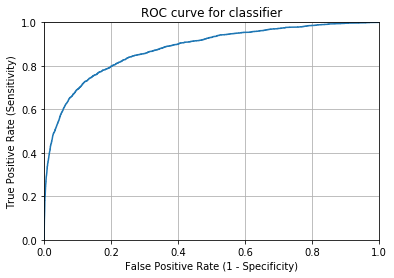

The following new features have been created: ['addr1_fe', 'addr2_fe', 'card2_fe', 'card3_fe', 'C1_fe', 'P_emaildomain_fe', 'card6_fe', 'V294_fe', 'V279_fe', 'C14_fe', 'V306_fe', 'D2_fe', 'D10_fe', 'card5_fe', 'V317_fe', 'V69_fe', 'D1_fe', 'D3_fe', 'D4_fe', 'D11_fe'] 

              precision    recall  f1-score   support

           0       1.00      0.23      0.37     56945
           1       0.04      0.98      0.09      2109

    accuracy                           0.26     59054
   macro avg       0.52      0.60      0.23     59054
weighted avg       0.96      0.26      0.36     59054


Printing df_scores...

      feat_tested     fn       fp  precision    recall  time_elapsed (min)  \
295          NaN  111.0  41907.0   0.045507  0.947368            3.737603   
296          NaN  148.0  38616.0   0.048328  0.929825            3.464711   
297          NaN  202.0  34923.0   0.051778  0.904220            3.527068   
298          NaN  297.0  29405.0   0.058045  0.859175            3.523

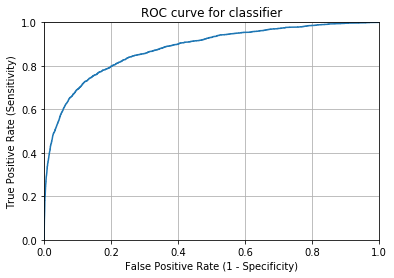

              precision    recall  f1-score   support

           0       1.00      0.35      0.52     56945
           1       0.05      0.96      0.10      2109

    accuracy                           0.37     59054
   macro avg       0.52      0.66      0.31     59054
weighted avg       0.96      0.37      0.50     59054


Printing df_scores...

      feat_tested     fn       fp  precision    recall  time_elapsed (min)  \
296          NaN  148.0  38616.0   0.048328  0.929825            3.464711   
297          NaN  202.0  34923.0   0.051778  0.904220            3.527068   
298          NaN  297.0  29405.0   0.058045  0.859175            3.523095   
299  model score   42.0  43909.0   0.044958  0.980085            6.979523   
0            NaN   80.0  37078.0   0.051883  0.962067            7.477363   

         tn       tp  
296  1961.0  18329.0  
297  1907.0  22022.0  
298  1812.0  27540.0  
299  2067.0  13036.0  
0    2029.0  19867.0  
PCA has been applied.
applying smote.
Fitting m

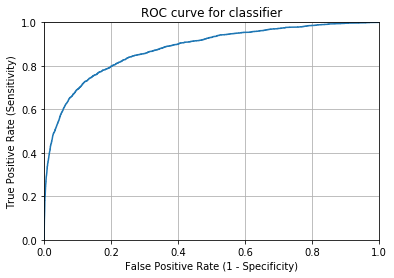

              precision    recall  f1-score   support

           0       1.00      0.45      0.62     56945
           1       0.06      0.94      0.11      2109

    accuracy                           0.47     59054
   macro avg       0.53      0.70      0.37     59054
weighted avg       0.96      0.47      0.61     59054


Printing df_scores...

      feat_tested     fn       fp  precision    recall  time_elapsed (min)  \
297          NaN  202.0  34923.0   0.051778  0.904220            3.527068   
298          NaN  297.0  29405.0   0.058045  0.859175            3.523095   
299  model score   42.0  43909.0   0.044958  0.980085            6.979523   
300          NaN   80.0  37078.0   0.051883  0.962067            7.477363   
0            NaN  117.0  31059.0   0.060270  0.944523            7.075246   

         tn       tp  
297  1907.0  22022.0  
298  1812.0  27540.0  
299  2067.0  13036.0  
300  2029.0  19867.0  
0    1992.0  25886.0  
PCA has been applied.
applying smote.
Fitting m

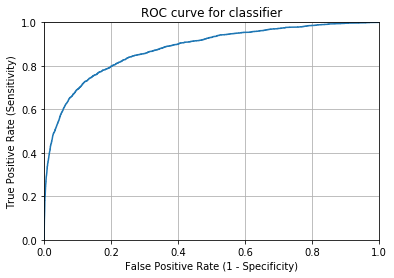

              precision    recall  f1-score   support

           0       0.99      0.55      0.71     56945
           1       0.07      0.91      0.13      2109

    accuracy                           0.56     59054
   macro avg       0.53      0.73      0.42     59054
weighted avg       0.96      0.56      0.69     59054


Printing df_scores...

      feat_tested     fn       fp  precision    recall  time_elapsed (min)  \
298          NaN  297.0  29405.0   0.058045  0.859175            3.523095   
299  model score   42.0  43909.0   0.044958  0.980085            6.979523   
300          NaN   80.0  37078.0   0.051883  0.962067            7.477363   
301          NaN  117.0  31059.0   0.060270  0.944523            7.075246   
0            NaN  180.0  25716.0   0.069778  0.914651            7.786568   

         tn       tp  
298  1812.0  27540.0  
299  2067.0  13036.0  
300  2029.0  19867.0  
301  1992.0  25886.0  
0    1929.0  31229.0  
PCA has been applied.
applying smote.
Fitting m

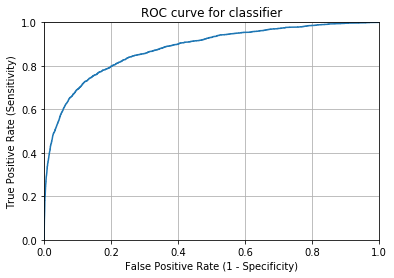

              precision    recall  f1-score   support

           0       0.99      0.63      0.77     56945
           1       0.08      0.89      0.15      2109

    accuracy                           0.64     59054
   macro avg       0.54      0.76      0.46     59054
weighted avg       0.96      0.64      0.75     59054


Printing df_scores...

      feat_tested     fn       fp  precision    recall  time_elapsed (min)  \
299  model score   42.0  43909.0   0.044958  0.980085            6.979523   
300          NaN   80.0  37078.0   0.051883  0.962067            7.477363   
301          NaN  117.0  31059.0   0.060270  0.944523            7.075246   
302          NaN  180.0  25716.0   0.069778  0.914651            7.786568   
0            NaN  235.0  20790.0   0.082686  0.888573            8.571868   

         tn       tp  
299  2067.0  13036.0  
300  2029.0  19867.0  
301  1992.0  25886.0  
302  1929.0  31229.0  
0    1874.0  36155.0  
PCA has been applied.
applying smote.
Fitting m

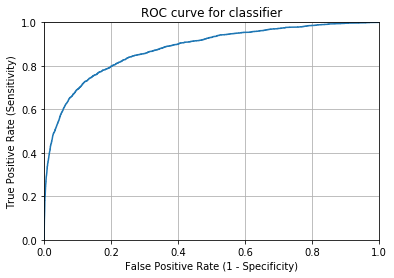

              precision    recall  f1-score   support

           0       0.99      0.71      0.83     56945
           1       0.10      0.85      0.18      2109

    accuracy                           0.72     59054
   macro avg       0.55      0.78      0.50     59054
weighted avg       0.96      0.72      0.81     59054


Printing df_scores...

     feat_tested     fn       fp  precision    recall  time_elapsed (min)  \
300         NaN   80.0  37078.0   0.051883  0.962067            7.477363   
301         NaN  117.0  31059.0   0.060270  0.944523            7.075246   
302         NaN  180.0  25716.0   0.069778  0.914651            7.786568   
303         NaN  235.0  20790.0   0.082686  0.888573            8.571868   
0           NaN  308.0  16470.0   0.098572  0.853959            7.770950   

         tn       tp  
300  2029.0  19867.0  
301  1992.0  25886.0  
302  1929.0  31229.0  
303  1874.0  36155.0  
0    1801.0  40475.0  
PCA has been applied.
applying smote.
Fitting model:


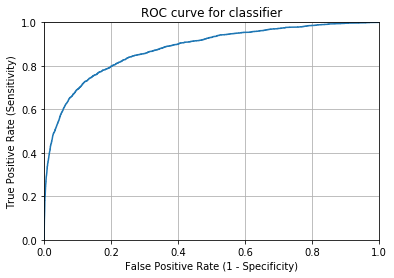

              precision    recall  f1-score   support

           0       0.99      0.77      0.87     56945
           1       0.12      0.82      0.20      2109

    accuracy                           0.77     59054
   macro avg       0.55      0.80      0.53     59054
weighted avg       0.96      0.77      0.84     59054


Printing df_scores...

     feat_tested     fn       fp  precision    recall  time_elapsed (min)  \
301         NaN  117.0  31059.0   0.060270  0.944523            7.075246   
302         NaN  180.0  25716.0   0.069778  0.914651            7.786568   
303         NaN  235.0  20790.0   0.082686  0.888573            8.571868   
304         NaN  308.0  16470.0   0.098572  0.853959            7.770950   
0           NaN  375.0  13199.0   0.116119  0.822191            7.155445   

         tn       tp  
301  1992.0  25886.0  
302  1929.0  31229.0  
303  1874.0  36155.0  
304  1801.0  40475.0  
0    1734.0  43746.0  
PCA has been applied.
applying smote.
Fitting model:


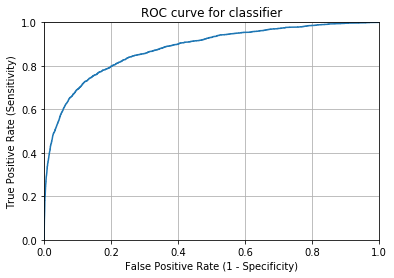

              precision    recall  f1-score   support

           0       0.99      0.81      0.89     56945
           1       0.13      0.79      0.23      2109

    accuracy                           0.81     59054
   macro avg       0.56      0.80      0.56     59054
weighted avg       0.96      0.81      0.87     59054


Printing df_scores...

     feat_tested     fn       fp  precision    recall  time_elapsed (min)  \
302         NaN  180.0  25716.0   0.069778  0.914651            7.786568   
303         NaN  235.0  20790.0   0.082686  0.888573            8.571868   
304         NaN  308.0  16470.0   0.098572  0.853959            7.770950   
305         NaN  375.0  13199.0   0.116119  0.822191            7.155445   
0           NaN  450.0  10654.0   0.134736  0.786629            7.560815   

         tn       tp  
302  1929.0  31229.0  
303  1874.0  36155.0  
304  1801.0  40475.0  
305  1734.0  43746.0  
0    1659.0  46291.0  


In [108]:
# #NEXT, look at predict proba results... then decide do more EDA..
# for val in [.1,.15,.2,.25,.3,.35,.4,.45]:
#     model.predict_proba_threshold = val
#     model_temp = LogisticRegression(random_state=42)
#     model.create_df_score_model(df_feat, fe.list_feat, model_temp)

bool_apply_pca set to false.
applying smote.
Fitting model:
 LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=42, solver='warn', tol=0.0001, verbose=0,
                   warm_start=False)


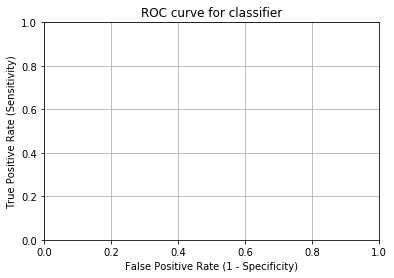

              precision    recall  f1-score   support

         0.0       1.00      0.93      0.96       100
         1.0       0.00      0.00      0.00         0

    accuracy                           0.93       100
   macro avg       0.50      0.47      0.48       100
weighted avg       1.00      0.93      0.96       100


Printing df_scores...

      feat_tested   fn   fp  precision  recall  time_elapsed (min)   tn    tp
286  model score  0.0  7.0        0.0     0.0            0.012777  0.0  93.0
287  model score  0.0  7.0        0.0     0.0            0.010395  0.0  93.0
288  model score  0.0  7.0        0.0     0.0            0.012261  0.0  93.0
289  model score  0.0  7.0        0.0     0.0            0.011565  0.0  93.0
0            NaN  0.0  7.0        0.0     0.0            0.013020  0.0  93.0


,TransactionID,isFraud,TransactionDT,TransactionAmt,card1,card2,card3,card5,C1,C2,...,card6_debit,card6_debit or credit,M1_T,M2_T,M3_T,M4_M1,M4_M2,M6_T,addr1_fe,addr2_fe
0,2987000,0,86400,68.50,3417,500,42,38,1.0,1.0,...,0,0,1,1,1,0,1,1,2.285776,1.0
1,2987001,0,86401,29.00,7922,303,42,2,1.0,1.0,...,0,0,1,1,1,0,0,1,3.288929,1.0
2,2987002,0,86469,59.00,9383,389,42,58,1.0,1.0,...,1,0,1,1,1,0,0,0,4.161296,1.0
3,2987003,0,86499,50.00,6991,466,42,14,2.0,5.0,...,1,0,1,1,1,0,0,0,4.120587,1.0
4,2987004,0,86506,50.00,9262,413,42,2,1.0,1.0,...,0,0,1,1,1,0,0,0,4.257885,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,2987995,0,112040,57.95,7962,0,42,108,5.0,4.0,...,1,0,1,1,1,0,0,0,3.762164,1.0
996,2987996,0,112070,100.00,11837,60,42,14,1.0,1.0,...,1,0,1,1,1,0,0,0,3.194300,1.0
997,2987997,0,112095,36.00,4787,213,42,106,4.0,2.0,...,1,0,1,1,1,0,0,0,2.738072,1.0
998,2987998,0,112125,800.00,11656,452,42,108,2.0,2.0,...,0,0,1,1,1,1,0,1,3.288929,1.0


In [97]:
model_temp = LogisticRegression(random_state=42)
model.create_df_score_model(df_feat, fe.list_feat, model_temp)
df_feat


In [ ]:
# df_feat

In [22]:
model_temp = DecisionTreeClassifier(random_state=42)
model.create_df_score_model(df_feat, fe.list_feat, model_temp)

PCA has been applied.
              precision    recall  f1-score   support

           0       0.98      0.94      0.96     56945
           1       0.24      0.54      0.33      2109

    accuracy                           0.92     59054
   macro avg       0.61      0.74      0.64     59054
weighted avg       0.96      0.92      0.94     59054


Printing df_scores...

      feat_tested     fn       fp  precision    recall  time_elapsed (min)  \
246     addr1_fe    0.0      9.0   0.000000  0.000000            0.009511   
247     addr1_fe    0.0      7.0   0.000000  0.000000            0.003268   
248     addr1_fe  534.0  12535.0   0.111623  0.746799           26.333495   
249  model score  508.0   8718.0   0.155151  0.759128            7.643815   
0            NaN  967.0   3685.0   0.236586  0.541489           21.727505   

         tn       tp  
246     0.0     91.0  
247     0.0     93.0  
248  1575.0  44410.0  
249  1601.0  48227.0  
0    1142.0  53260.0  


In [ ]:
model_temp = SVC(random_state=42)
model.create_df_score_model(df_feat, fe.list_feat, model_temp, verbose=True)

PCA has been applied.
Smote has been applied.
Fitting model from.. SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='auto_deprecated',
    kernel='rbf', max_iter=-1, probability=False, random_state=42,
    shrinking=True, tol=0.001, verbose=False)


In [ ]:
# model.create_df_score_model(df_feat)
# 369.0 all col
# 398.0 remove P_emaildomain
# 410.0 remove card6
# 395.0 drop C4
# 415.0 add all back in
# 368.0 test again with C14


In [ ]:
# # there after, we can decide on our feature set and move on with the project. We need to add SVM and DT in our
# # model class. Then we need to tune the models. 
# model tuning is next... we do need to include a proba method.. 
# create feature from TransactionAmt. Add more EDA information. 
# NEXT, clean up code and figure out what to do next. 

In [ ]:
# 1. Model Tuning
# 2. Finished - Features
# 3. We need to do eda.
# 4. move pca and smote into fe. 

In [ ]:
df_temp_read = pd.read_csv('/Users/krahman/work/fraud_detection/saved_files/df_scores.csv')
df_temp_read[len(df_temp_read)-40:]

In [ ]:
# # it reads the csv, creates a dataframe, then appends the results, then saves over the old version and keeps
# # a record of all columns in the tested dataframe.

# X = df_features.drop(col_target, axis=1)
# X = X.drop(col_id, axis=1)
# y = df_features[col_target]

# # we want to test a feature for feature engineering... we must 

# for col_original, col_new in zip(list_col, fe.list_new_feat):
#     print(col_original, col_new)
#     X[col_new] = fe.df_feat[col_new]
#     X = X.drop(col_original, axis=1)

#     X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42)
#     start_time = time.time()

#     sm = SMOTE(random_state=42, ratio=1.0, n_jobs=-1) # SMOTE
#     X_train_res, y_train_res = sm.fit_sample(X_train, y_train)
    
#     model_lr_pca_sm = LogisticRegression(random_state=42, n_jobs=-1) # logistic regression
#     model_lr_pca_sm.fit(X_train_res, y_train_res)
    
#     y_pred = model_lr_pca_sm.predict(X_test)     # predict
    
#     elapsed_time = time.time() - start_time
#     print('\nTime elapsed:', elapsed_time / 60)
#     print(confusion_matrix(y_test, y_pred))
#     print(classification_report(y_test, y_pred))
    
# #     X = X.drop(col, axis=1)
#     print(list(X.columns))

In [ ]:
# fe.df_feat['time_delta'] = df_temp['time_delta']
# fe.df_feat['time_delta_week'] = df_temp['time_delta']/7
# fe.df_feat['time_delta_month'] = df_temp['time_delta']/30
# fe.df_feat

In [ ]:
# fe.df_feat = fe.df_feat.drop(['time_delta_fe','time_delta_fe_week'],axis=1)
# list(fe.df_feat.columns)

In [ ]:
# fe.df_feat['TransactionAmt'] = df_features['TransactionAmt']
# list(fe.df_feat)
# fe.list_new_feat

In [ ]:
# fe.df_feat = fe.df_feat.drop(['time_delta_fe','addr1_fe'],axis=1)
# list(fe.df_feat.columns)

In [ ]:
# KEEP
# val_aggreg = 'TransactionAmt'
# list_col = ['card2', 'C4', 'C1', 'V317', 'ProductCD', 'V294', 'V279', 'C14', 'card6', 'V306', 'V69']
# fe.aggregate_features(list_col, val_aggreg)
# list(fe.df_feat.columns)

In [ ]:
##### implement into feature engineering class. days lapsed
df_temp = fe.df_feat[['TransactionDT']]
df_temp['time_delta'] = 0
len_df_temp = df_temp.shape[0]
for i in range(1,len(df_temp['TransactionDT'][0:len_df_temp])):
    val_time_1 = df_temp.loc[i - 1, 'TransactionDT']
    val_time_2 = df_temp.loc[i, 'TransactionDT']
    val_time_delta = val_time_2 - val_time_1
    df_temp.loc[i, 'time_delta'] = val_time_delta

In [ ]:
# KEEP
# class Results():
#     def __init__(self):
#         self.model_lr_results = pd.DataFrame()
#         self.model_recall = []
#         self.model_precision = []
# #         self.model_auc_score = []
        
#     def _score(self, y_true, y_pred):
#         self.model_recall.append(recall_score(y_true, y_pred))
#         self.model_precision.append(precision_score(y_true, y_pred))
#         self._create_series()
# #         self.model_auc_score.append(roc_auc_score(y_true, y_pred[:,1]))

#     def _create_series(self):
#         model_recall = pd.Series(self.model_recall, name='recall')
#         model_precision = pd.Series(self.model_precision, name='precision')
# #         model_auc_score = pd.Series(self.model_auc_score, name='auc_score')
#         model_results_final = pd.concat([model_recall, model_precision],axis=1)
#         return model_results_final

In [ ]:
# X = df_features.drop(col_target, axis=1)
# X = X.drop(col_id, axis=1)
# y = df_features[col_target]

# X = fe.df_feat.drop(col_target, axis=1)
# X = X.drop(col_id, axis=1)
# y = df_features[col_target]
# list(X.columns)

In [ ]:
# list(X.columns)

#### LogisticRegression Base

In [ ]:
# NEXT, get our score working properly again... What did we do to score 
# LogisticRegression Base
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42)
start_time = time.time()
# applying SMOTE
sm = SMOTE(random_state=42, ratio=1.0, n_jobs=-1)
X_train_res, y_train_res = sm.fit_sample(X_train, y_train)
# fit logistic regression
model_lr_pca_sm = LogisticRegression(random_state=42, n_jobs=-1)
model_lr_pca_sm.fit(X_train_res, y_train_res)
# predict
y_pred = model_lr_pca_sm.predict(X_test)
# time
elapsed_time = time.time() - start_time
print('\nTime elapsed:', elapsed_time / 60)
print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))

# BASE SCORE
# Time elapsed: 4.251827295621236
# [[33985 22960]
#  [  601  1508]]
#               precision    recall  f1-score   support

#            0       0.98      0.60      0.74     56945
#            1       0.06      0.72      0.11      2109

#     accuracy                           0.60     59054
#    macro avg       0.52      0.66      0.43     59054
# weighted avg       0.95      0.60      0.72     59054

# RESULT: addr1_fe only

# RESULT: time_delta_fe, addr1
# Time elapsed: 5.163579479853312
# [[26551 30394]
#  [  363  1746]]
#               precision    recall  f1-score   support

#            0       0.99      0.47      0.63     56945
#            1       0.05      0.83      0.10      2109

#     accuracy                           0.48     59054
#    macro avg       0.52      0.65      0.37     59054
# weighted avg       0.95      0.48      0.61     59054

# RESULT: time_delta_fe, time_delta_week_fe
# Time elapsed: 3.142271514733632
# [[32540 24405]
#  [  560  1549]]
#               precision    recall  f1-score   support

#            0       0.98      0.57      0.72     56945
#            1       0.06      0.73      0.11      2109

#     accuracy                           0.58     59054
#    macro avg       0.52      0.65      0.42     59054
# weighted avg       0.95      0.58      0.70     59054


# RESULT: created time_delta_fe
# Time elapsed: 3.1532896359761557
# [[26260 30685]
#  [  359  1750]]
#               precision    recall  f1-score   support

#            0       0.99      0.46      0.63     56945
#            1       0.05      0.83      0.10      2109

#     accuracy                           0.47     59054
#    macro avg       0.52      0.65      0.36     59054
# weighted avg       0.95      0.47      0.61     59054

# RESULT: time_delta_fe only. dropping addr1_fe
# Time elapsed: 6.11533077955246
# [[26893 30052]
#  [  365  1744]]
#               precision    recall  f1-score   support

#            0       0.99      0.47      0.64     56945
#            1       0.05      0.83      0.10      2109

#     accuracy                           0.48     59054
#    macro avg       0.52      0.65      0.37     59054
# weighted avg       0.95      0.48      0.62     59054

In [ ]:
fe.list_new_feat
'TransactionAmt_fe', 'card1_fe', 'card2_fe','card3_fe', 'card5_fe', 'addr1_fe', 'addr2_fe'

#### LogisticRegression feature testing

In [ ]:
X = df_features.drop(col_target, axis=1)
X = X.drop(col_id, axis=1)
y = df_features[col_target]

In [ ]:
# Testing 'TransactionAmt_fe', 'card1_fe', 'card2_fe','card3_fe', 'card5_fe', 'addr1_fe', 'addr2_fe'
# Good: addr2_fe, 
# Bad: TransactionAmt_fe, card1_fe, card2_fe, card3_fe, card5_fe
# build a function that after a feature is created, you then have it test the feature and provide you results.. 

for col_original, col_new in zip(list_col, fe.list_new_feat):
    print(col_original, col_new)
    X[col_new] = fe.df_feat[col_new]
    X = X.drop(col_original, axis=1)

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42)
    start_time = time.time()
    sm = SMOTE(random_state=42, ratio=1.0, n_jobs=-1) # SMOTE
    X_train_res, y_train_res = sm.fit_sample(X_train, y_train)
    model_lr_pca_sm = LogisticRegression(random_state=42, n_jobs=-1) # logistic regression
    model_lr_pca_sm.fit(X_train_res, y_train_res)
    y_pred = model_lr_pca_sm.predict(X_test)     # predict
    elapsed_time = time.time() - start_time
    print('\nTime elapsed:', elapsed_time / 60)
    print(confusion_matrix(y_test, y_pred))
    print(classification_report(y_test, y_pred))
#     X = X.drop(col, axis=1)
    print(list(X.columns))
# RESULTS: Base: 601

# RESULTS

In [ ]:
# # good fe: C2_fe, card2_fe, V294_fe, V317_fe, V279_fe, V306_fe
# # bad fe: C1_fe, ProductCD_fe, V294_fe, C14_fe, card6_fe, V69_fe
# for col in list_col_fe:
#     X[col] = fe.df_feat[col]    
#     print(col)
    
#     X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42)
#     start_time = time.time()
#     sm = SMOTE(random_state=42, ratio=1.0, n_jobs=-1) # SMOTE
#     X_train_res, y_train_res = sm.fit_sample(X_train, y_train)
#     model_lr_pca_sm = LogisticRegression(random_state=42, n_jobs=-1) # logistic regression
#     model_lr_pca_sm.fit(X_train_res, y_train_res)
#     y_pred = model_lr_pca_sm.predict(X_test)     # predict
#     elapsed_time = time.time() - start_time
#     print('\nTime elapsed:', elapsed_time / 60)
#     print(confusion_matrix(y_test, y_pred))
#     print(classification_report(y_test, y_pred))
#     X = X.drop(col, axis=1)
    
# # good: C2_fe, 
# # not good: card2_fe, C4_fe 

In [ ]:
# prior information 
# C2_fe

# Time elapsed: 6.717598664760589
# [[33735 23210]
#  [  595  1514]]
#               precision    recall  f1-score   support

#            0       0.98      0.59      0.74     56945
#            1       0.06      0.72      0.11      2109

#     accuracy                           0.60     59054
#    macro avg       0.52      0.66      0.43     59054
# weighted avg       0.95      0.60      0.72     59054

# card2_fe

# Time elapsed: 7.546754765510559
# [[35200 21745]
#  [  649  1460]]
#               precision    recall  f1-score   support

#            0       0.98      0.62      0.76     56945
#            1       0.06      0.69      0.12      2109

#     accuracy                           0.62     59054
#    macro avg       0.52      0.66      0.44     59054
# weighted avg       0.95      0.62      0.74     59054

# C4_fe

# Time elapsed: 5.034457282225291
# [[36521 20424]
#  [  602  1507]]
#               precision    recall  f1-score   support

#            0       0.98      0.64      0.78     56945
#            1       0.07      0.71      0.13      2109

#     accuracy                           0.64     59054
#    macro avg       0.53      0.68      0.45     59054
# weighted avg       0.95      0.64      0.75     59054

# C1_fe

# Time elapsed: 5.847904968261719
# [[40085 16860]
#  [  701  1408]]
#               precision    recall  f1-score   support

#            0       0.98      0.70      0.82     56945
#            1       0.08      0.67      0.14      2109

#     accuracy                           0.70     59054
#    macro avg       0.53      0.69      0.48     59054
# weighted avg       0.95      0.70      0.80     59054

# V317_fe

# Time elapsed: 4.49170538187027
# [[33842 23103]
#  [  583  1526]]
#               precision    recall  f1-score   support

#            0       0.98      0.59      0.74     56945
#            1       0.06      0.72      0.11      2109

#     accuracy                           0.60     59054
#    macro avg       0.52      0.66      0.43     59054
# weighted avg       0.95      0.60      0.72     59054

# ProductCD_fe

# Time elapsed: 5.576840949058533
# [[41354 15591]
#  [  737  1372]]
#               precision    recall  f1-score   support

#            0       0.98      0.73      0.84     56945
#            1       0.08      0.65      0.14      2109

#     accuracy                           0.72     59054
#    macro avg       0.53      0.69      0.49     59054
# weighted avg       0.95      0.72      0.81     59054

# V294_fe

# Time elapsed: 4.640570282936096
# [[37922 19023]
#  [  698  1411]]
#               precision    recall  f1-score   support

#            0       0.98      0.67      0.79     56945
#            1       0.07      0.67      0.13      2109

#     accuracy                           0.67     59054
#    macro avg       0.53      0.67      0.46     59054
# weighted avg       0.95      0.67      0.77     59054

# V279_fe

# Time elapsed: 3.3400171319643657
# [[33443 23502]
#  [  577  1532]]
#               precision    recall  f1-score   support

#            0       0.98      0.59      0.74     56945
#            1       0.06      0.73      0.11      2109

#     accuracy                           0.59     59054
#    macro avg       0.52      0.66      0.42     59054
# weighted avg       0.95      0.59      0.71     59054

# C14_fe

# Time elapsed: 6.974740914503733
# [[35823 21122]
#  [  599  1510]]
#               precision    recall  f1-score   support

#            0       0.98      0.63      0.77     56945
#            1       0.07      0.72      0.12      2109

#     accuracy                           0.63     59054
#    macro avg       0.53      0.67      0.44     59054
# weighted avg       0.95      0.63      0.74     59054

# card6_fe

# Time elapsed: 3.6439321478207907
# [[36705 20240]
#  [  640  1469]]
#               precision    recall  f1-score   support

#            0       0.98      0.64      0.78     56945
#            1       0.07      0.70      0.12      2109

#     accuracy                           0.65     59054
#    macro avg       0.53      0.67      0.45     59054
# weighted avg       0.95      0.65      0.76     59054

# V306_fe

# Time elapsed: 2.792719868818919
# [[34359 22586]
#  [  592  1517]]
#               precision    recall  f1-score   support

#            0       0.98      0.60      0.75     56945
#            1       0.06      0.72      0.12      2109

#     accuracy                           0.61     59054
#    macro avg       0.52      0.66      0.43     59054
# weighted avg       0.95      0.61      0.73     59054

# V69_fe

# Time elapsed: 5.5301028688748675
# [[39833 17112]
#  [  694  1415]]
#               precision    recall  f1-score   support

#            0       0.98      0.70      0.82     56945
#            1       0.08      0.67      0.14      2109

#     accuracy                           0.70     59054
#    macro avg       0.53      0.69      0.48     59054
# weighted avg       0.95      0.70      0.79     59054

In [ ]:
# RESULT: C4_fe with TransactionAmt

# RESULT: Base Score, smote only, no pca
# [[245073 267859]
#  [  3447  15107]]
#               precision    recall  f1-score   support

#            0       0.99      0.48      0.64    512932
#            1       0.05      0.81      0.10     18554

#     accuracy                           0.49    531486
#    macro avg       0.52      0.65      0.37    531486
# weighted avg       0.95      0.49      0.62    531486

# Scores below reflect _fe's
# RESULTS: drop card6_fe
# Time elapsed: 3.520830734570821
# [[361114 151818]
#  [  4823  13731]]
#               precision    recall  f1-score   support

#            0       0.99      0.70      0.82    512932
#            1       0.08      0.74      0.15     18554

#     accuracy                           0.71    531486
#    macro avg       0.53      0.72      0.49    531486
# weighted avg       0.96      0.71      0.80    531486

# RESULTS: card6_fe 
# Time elapsed: 3.569287049770355
# [[362083 150849]
#  [  4745  13809]]
#               precision    recall  f1-score   support

#            0       0.99      0.71      0.82    512932
#            1       0.08      0.74      0.15     18554

#     accuracy                           0.71    531486
#    macro avg       0.54      0.73      0.49    531486
# weighted avg       0.96      0.71      0.80    531486

# RESULTS: dropped features and used PCA, worstened score
# [[413977  98955]
#  [  4747  13807]]
#               precision    recall  f1-score   support

#            0       0.99      0.81      0.89    512932
#            1       0.12      0.74      0.21     18554

#     accuracy                           0.80    531486
#    macro avg       0.56      0.78      0.55    531486
# weighted avg       0.96      0.80      0.87    531486

# RESULTS: drop low ranking features found in decision tree
# [[329812 183120]
#  [  4810  13744]]
#               precision    recall  f1-score   support

#            0       0.99      0.64      0.78    512932
#            1       0.07      0.74      0.13     18554

#     accuracy                           0.65    531486
#    macro avg       0.53      0.69      0.45    531486
# weighted avg       0.95      0.65      0.76    531486

# RESULTS: without PCA
# [[298715 214217]
#  [  3509  15045]]
#               precision    recall  f1-score   support

#            0       0.99      0.58      0.73    512932
#            1       0.07      0.81      0.12     18554

#     accuracy                           0.59    531486
#    macro avg       0.53      0.70      0.43    531486
# weighted avg       0.96      0.59      0.71    531486

# RESULTS: keep ohe for email and create p email feature calculate email domain fraud feature
# [[434421  78511]
#  [  4429  14125]]
#               precision    recall  f1-score   support

#            0       0.99      0.85      0.91    512932
#            1       0.15      0.76      0.25     18554

#     accuracy                           0.84    531486
#    macro avg       0.57      0.80      0.58    531486
# weighted avg       0.96      0.84      0.89    531486

# RESULTS: with new feature, try dropping ohe p_email and test
# [[435499  77433]
#  [  4539  14015]]
#               precision    recall  f1-score   support

#            0       0.99      0.85      0.91    512932
#            1       0.15      0.76      0.25     18554

#     accuracy                           0.85    531486
#    macro avg       0.57      0.80      0.58    531486
# weighted avg       0.96      0.85      0.89    531486

# RESULTS: cut FP rate quite a bit. fixing fraud perc calculation by doing fraud/non fraud for each value in each column
# [[434423  78509]
#  [  4430  14124]]
#               precision    recall  f1-score   support

#            0       0.99      0.85      0.91    512932
#            1       0.15      0.76      0.25     18554

#     accuracy                           0.84    531486
#    macro avg       0.57      0.80      0.58    531486
# weighted avg       0.96      0.84      0.89    531486


# RESULTS: adding 60 for one hot encoding
# [[403339 109593]
#  [  4393  14161]]
#               precision    recall  f1-score   support

#            0       0.99      0.79      0.88    512932
#            1       0.11      0.76      0.20     18554

#     accuracy                           0.79    531486
#    macro avg       0.55      0.77      0.54    531486
# weighted avg       0.96      0.79      0.85    531486

# RESULTS: fe for 'addr1', 'addr2', 'card1', 'card2', 'card3', 'card5'
# [[397116 115816]
#  [  4490  14064]]
#               precision    recall  f1-score   support

#            0       0.99      0.77      0.87    512932
#            1       0.11      0.76      0.19     18554

#     accuracy                           0.77    531486
#    macro avg       0.55      0.77      0.53    531486
# weighted avg       0.96      0.77      0.84    531486

# RESULTS: only addr6. Creating ratio ranking of higher risk areas for fraud. 
# [[396866 116066]
#  [  4534  14020]]
#               precision    recall  f1-score   support

#            0       0.99      0.77      0.87    512932
#            1       0.11      0.76      0.19     18554

#     accuracy                           0.77    531486
#    macro avg       0.55      0.76      0.53    531486
# weighted avg       0.96      0.77      0.84    531486

# NEXT, test creating iqr range instead of percentage values, instead of what we did
# with addr5, then create one for addr2, then create an addr7 based on interaction with addr2. 



# RESULTS: only addr5. testing mapping percentage values transformed..
# [[396898 116034]
#  [  4535  14019]]
#               precision    recall  f1-score   support

#            0       0.99      0.77      0.87    512932
#            1       0.11      0.76      0.19     18554

#     accuracy                           0.77    531486
#    macro avg       0.55      0.76      0.53    531486
# weighted avg       0.96      0.77      0.84    531486

# RESULTS: with only addr3, addr4
# [[396868 116064]
#  [  4544  14010]]
#               precision    recall  f1-score   support

#            0       0.99      0.77      0.87    512932
#            1       0.11      0.76      0.19     18554

#     accuracy                           0.77    531486
#    macro avg       0.55      0.76      0.53    531486
# weighted avg       0.96      0.77      0.84    531486

# RESULTS: w/o addr1, addr2, addr3, addr4
# [[396629 116303]
#  [  4545  14009]]

#               precision    recall  f1-score   support

#            0       0.99      0.77      0.87    512932
#            1       0.11      0.76      0.19     18554

#     accuracy                           0.77    531486
#    macro avg       0.55      0.76      0.53    531486
# weighted avg       0.96      0.77      0.84    531486

# RESULTS: with only addr1, addr2
# [[396803 116129]
#  [  4555  13999]]
#               precision    recall  f1-score   support

#            0       0.99      0.77      0.87    512932
#            1       0.11      0.75      0.19     18554

#     accuracy                           0.77    531486
#    macro avg       0.55      0.76      0.53    531486
# weighted avg       0.96      0.77      0.84    531486

# RESULTS: with addr1, addf2, addr3, addr4
# [[396877 116055]
#  [  4549  14005]]
#               precision    recall  f1-score   support

#            0       0.99      0.77      0.87    512932
#            1       0.11      0.75      0.19     18554

#     accuracy                           0.77    531486
#    macro avg       0.55      0.76      0.53    531486
# weighted avg       0.96      0.77      0.84    531486

In [ ]:
# decision tree smote only (pca commented out)
X_train2, X_test2, y_train2, y_test2 = train_test_split(X, y, test_size=0.1, random_state=42)

# # applying PCA
# scaled_X = StandardScaler().fit_transform(X)
# # pca = PCA(n_components=250)
# pca = PCA()
# pcomponents = pca.fit_transform(scaled_X)
# X_pca = pd.DataFrame(data=pcomponents)
# X_train2, X_test2, y_train2, y_test2 = train_test_split(X_pca, y, test_size=0.1, random_state=42)

start_time = time.time()
# applying SMOTE
sm = SMOTE(random_state=42, ratio=1.0, n_jobs=-1)
X_train_res, y_train_res = sm.fit_sample(X_train2, y_train2)

model_dt_pca_smote = DecisionTreeClassifier(random_state=42)
model_dt_pca_smote.fit(X_train_res, y_train_res)
elapsed_time = time.time() - start_time
print('\nTime elapsed:', elapsed_time / 60)

# Feature importance
col_name = pd.Series(X.columns, name='col')
col_feat_rank = pd.Series(model_dt_pca_smote.feature_importances_, name='feat_rank')
df_feat_rank = pd.concat([col_name, col_feat_rank], axis=1).sort_values('feat_rank', ascending=False)

plt.figure(figsize=(5,6))
sns.barplot(df_feat_rank.feat_rank[0:10], df_feat_rank.col[0:10], palette='Blues_d')
plt.title('Feature Importance')
plt.show()
df_feat_rank[0:40]

In [ ]:
# # EDA on C4 and TransactionAmt
# df_temp = fe.df_feat

# sns.lineplot(x='C4', y='TransactionAmt', data=df_temp)
# plt.title('C4 versus Transaction Amount')
# plt.show()

# sns.scatterplot(x='C4', y='TransactionAmt', hue='isFraud', data=df_temp)
# plt.title('C4 versus Transaction Amount')
# plt.show()

In [ ]:
# the type of card is highly correllated with debit, credit, etc. figure out which feature to create. 

In [ ]:
# y_pred = model_lr_pca_sm.predict(X_pca)

# cross validation
# result = cross_val_score(model_lr_pca_sm, X_train2, y_train2, cv=10, n_jobs=-1, scoring='recall_score')
# result.mean()

In [ ]:
# notes, do we need to visualize our results?? We need to look at our confusion matrix
# and decide how to improve our results from here... Test and see what happens if we 
# increase our principal components... test removing columns, adding columns, imputing
# certain columns all together. 

# test imputing 500 or less for ohe. Then test dropping card1 due to its number
# of unique values that would make our data very high dimensional. We can try only ohe for
# the entire dataset to see how our model performs over all... Though.. it will likely run 
# out of memory and crash. 

# ALSO test probabilities on logisticregression


### Predict Proba

In [ ]:
# %matplotlib inline
# plt.rcParams['font.size'] = 14

# y_pred_prob = model_lr_pca.predict_proba(X_pca)
# plt.hist(y_pred_prob[:,1], bins=8)
# plt.xlim(0,1)
# plt.title("Histogram of Probability of Fraud")
# plt.xlabel("Predicted probability of Fraud")
# plt.ylabel("Frequency")

# y_pred_prob = model_lr_pca.predict_proba(X_pca)
# y_pred_class = binarize(y_pred_prob, 0.5)[:,1]

# print(confusion_matrix(y, y_pred_class))
# print(classification_report(y, y_pred_class))

# fpr, tpr, thresholds = roc_curve(y, y_pred_prob[:,1])
# plt.plot(fpr, tpr)
# plt.xlim([0.0, 1.0])
# plt.ylim([0.0, 1.0])
# plt.title("ROC curve for fraud detection classifier")
# plt.xlabel("False Positive Rate (1 - Specificity)")
# plt.ylabel("True Positive Rate (Sensitivity)")
# plt.grid(True)
# plt.show()

In [ ]:
# def evaluate_threshold(threshold):
#     print("Sensitivity:", tpr[thresholds > threshold][-1])
#     print("Specificity:", 1 - fpr[thresholds > threshold][-1],'\n')
    
# evaluate_threshold(.5)
# evaluate_threshold(.2)
# evaluate_threshold(.1)

# print(roc_auc_score(y, y_pred_prob[:,1]))

In [ ]:
# y_pred_actual = model_lr_pca.predict(X_test2) # actual prediction test data set
# print('y_pred_actual on test set\n')
# print(y_pred_actual[0:10])
# print(confusion_matrix(y_test2, y_pred_actual))
# print(classification_report(y_test2, y_pred_actual))

# print('y_pred_proba\n')
# y_pred_proba = model_lr_pca.predict_proba(X_test2)
# y_pred_class = binarize(y_pred_proba, 0.5)[:,1]
# print(y_pred_class[0:10])
# print(confusion_matrix(y_test2, y_pred_class))
# print(classification_report(y_test2, y_pred_class))

In [ ]:
# y_pred_actual = model_lr_pca.predict(X_pca) # actual full data set
# print('Logistic Regression')
# print('y_pred_actual full data set\n')
# print(y_pred_actual[0:10])
# print(confusion_matrix(y, y_pred_actual))
# print(classification_report(y, y_pred_actual))

# print('y_pred_proba full data set\n')
# y_pred_proba = model_lr_pca.predict_proba(X_pca)#[:,1]#[0:10]
# y_pred_class = binarize(y_pred_proba, 0.2)[:,1]
# print(y_pred_class[0:10])
# print(confusion_matrix(y, y_pred_class))
# print(classification_report(y, y_pred_class))

In [ ]:
# # predicting on test set w/o PCA
# print("Predicting using Logistic Regression, PCA, SMOTE\n")
# y_pred_pca_sm = model_lr_pca.predict(X_test2)
# # y_pred_test1 = model_lr.predict(X_test1)
# print("Test set:")
# print("Validation results")
# print(model_lr_pca.score(X_test2, y_test2))
# print(recall_score(y_test2, y_pred_pca_sm))
# print("\nConfusion Matrix")
# print(confusion_matrix(y_test2, y_pred_pca_sm))
# print('\nClassification Report:\n')
# print(classification_report(y_test2, y_pred_pca_sm))

# # predicting on original dataset
# print("Whole dataset:")
# y_pred_pca_sm_whole = model_lr_pca.predict(X_pca)
# print("\nTest Results")
# print(model_lr_pca.score(X_pca, y))
# print(recall_score(y, y_pred_pca_sm_whole))
# print("\nConfusion Matrix")
# print(confusion_matrix(y, y_pred_pca_sm_whole))
# print('\nClassification Report:\n')
# print(classification_report(y, y_pred_pca_sm_whole))

In [ ]:
# print('dataframe length: ' + str(df_features.shape[0]))
# print('TransactionDT unique: ' + str(len(df_features.TransactionDT.unique())))
# print('is not fraud: ' + str(df_features[df_features.isFraud==0].shape[0]))
# print('is fraud: ' + str(df_features[df_features.isFraud==1].shape[0]))

In [ ]:
# # KEEP
# fig = plt.figure(figsize=(15,4))
# df_temp = df_features
# sns.kdeplot(df_temp.loc[(df_temp.isFraud==0), 'TransactionDT'], color='b', shade=True, label='Not Fraud')
# sns.kdeplot(df_temp.loc[(df_temp.isFraud==1), 'TransactionDT'], color='r', shade=True, label='Fraud')
# plt.title('Transaction Date Versus Fraud')
# plt.show()

In [ ]:
# sns.barplot(x='TransactionDT', y='TransactionDT', hue='isFraud', data=df_features)
# plt.title("Transaction Date Versus Fraud")
# plt.show()

# we want to figure out how to create more features from TransactionDT.. 
# are certain transactions more likely. in general, to be fraudualant around a certain day? 
# we have transactionID yet we dont have the specific card of who it belongs to.. 
# if card1 is the unique identifier... and we did a groupby on fraud.. 
# we have average spent per day as an option... 
# create a feature that is average spent per day for non fraud versus average spent per day for fraud.. 
# what would the describe method reveal for us? 

In [ ]:
# # predicting on test set w/o PCA
# print("Predicting using PCA\n")
# y_pred_pca = model_dt_pca_smote.predict(X_test2)
# # y_pred_test1 = model_lr.predict(X_test1)
# print("Test set:")
# print("Validation results")
# print(model_dt_pca_smote.score(X_test2, y_test2))
# print(recall_score(y_test2, y_pred_pca))
# print("\nConfusion Matrix")
# print(confusion_matrix(y_test2, y_pred_pca))
# print('\nClassification Report:\n')
# print(classification_report(y_test2, y_pred_pca))

# # predicting on original dataset
# print("Whole dataset:")
# y_pred_pca = model_dt_pca_smote.predict(X_pca)
# print("\nTest Results")
# print(model_dt_pca_smote.score(X_pca, y))
# print(recall_score(y, y_pred_pca))
# print("\nConfusion Matrix")
# print(confusion_matrix(y, y_pred_pca))
# print('\nClassification Report:\n')
# print(classification_report(y, y_pred_pca))

In [ ]:
# print("Variance ratio:")
# print(pca.explained_variance_ratio_)
# print("\nPrincipal components explained:")
# pd.DataFrame(pca.components_, columns=list(X.columns), index=('PC1', 'PC2'))

In [ ]:
# # explaining variance
# print('Variance ratio:')
# print(pca.explained_variance_ratio_)
# # interpreting principal components
# print('\nPrincipal components explained:')
# pd.DataFrame(pca.components_, columns=list(X.columns), index=('PC1', 'PC2'))

# # # predicting on original dataset
# # y_pred = clf_lr.predict(X)
# # print("\nTest Results")
# # print(clf_lr.score(X, y))
# # print(recall_score(y, y_pred))
# # print("\nConfusion Matrix")
# # print(confusion_matrix(y, y_pred))
# # print('\nClassification Report:\n')
# # print(classification_report(y, y_pred))

In [ ]:
# scaled_X2 = StandardScaler().fit_transform(X)
# pca3 = PCA(n_components=275)
# pcomponents = pca3.fit_transform(scaled_X2)
# X_pca = pd.DataFrame(data=pcomponents)

## Applying SMOTE

In [ ]:
# # applying SMOTE to train set to correct class imbalance
# sm = SMOTE(random_state=42, ratio = 1.0, n_jobs=-1)
# X_train_res, y_train_res = sm.fit_sample(X_train, y_train)

# # fitting to residuals created by SMOTE
# clf_lr = LogisticRegression(class_weight='balanced', random_state=42)
# clf_lr.fit(X_train_res, y_train_res);

# # predicting on test set
# y_test_pred = clf_lr.predict(X_test)
# print("Validation results")
# print(clf_lr.score(X_test, y_test))
# print(recall_score(y_test, y_test_pred))
# print("\nConfusion Matrix")
# print(confusion_matrix(y_test, y_test_pred))
# print('\nClassification Report:\n')
# print(classification_report(y_test, y_test_pred))

# # predicting on original dataset
# y_pred = clf_lr.predict(X)
# print("\nTest Results")
# print(clf_lr.score(X, y))
# print(recall_score(y, y_pred))
# print("\nConfusion Matrix")
# print(confusion_matrix(y, y_pred))
# print('\nClassification Report:\n')
# print(classification_report(y, y_pred))

In [ ]:
# print("\nConfusion Matrix")
# print(confusion_matrix(y, y_pred))
# print('\nClassification Report:\n')
# print(classification_report(y, y_pred))